---
title       : "Introduction to Neural Networks" 
subtitle    : "Single Layer Perceptrons"
author      : Paul Schrimpf
date        : `j using Dates; print(Dates.today())`
bibliography: "../ml.bib"
options:
      out_width : 100%
      wrap : true
      fig_width : 800
      dpi : 192
---

[![](https://i.creativecommons.org/l/by-sa/4.0/88x31.png)](http://creativecommons.org/licenses/by-sa/4.0/)

This work is licensed under a [Creative Commons Attribution-ShareAlike
4.0 International
License](http://creativecommons.org/licenses/by-sa/4.0/) 


### About this document 

This document was created using Weave.jl. The code is available in
[on github](https://github.com/schrimpf/NeuralNetworkEconomics.jl). The same
document generates both static webpages and associated [jupyter
notebook](slp.ipynb). 

$$
\def\indep{\perp\!\!\!\perp}
\def\Er{\mathrm{E}}
\def\R{\mathbb{R}}
\def\En{{\mathbb{E}_n}}
\def\Pr{\mathrm{P}}
\newcommand{\norm}[1]{\left\Vert {#1} \right\Vert}
\newcommand{\abs}[1]{\left\vert {#1} \right\vert}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
$$

In [1]:
markdown = try
  "md" in keys(WEAVE_ARGS) && WEAVE_ARGS["md"]
catch
  false
end

if !("DISPLAY" ∈ keys(ENV))
  # Make gr and pyplot backends for Plots work without a DISPLAY
  ENV["GKSwstype"]="nul"
  ENV["MPLBACKEND"]="Agg"
end
# Make gr backend work with λ and other unicode
ENV["GKS_ENCODING"] = "utf-8"

using NeuralNetworkEconomics
docdir = joinpath(dirname(Base.pathof(NeuralNetworkEconomics)), "..","docs")

using Pkg
Pkg.activate(docdir)
Pkg.instantiate()

Activating environment at `~/.julia/dev/NeuralNetworkEconomics/docs/Project.toml`
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


# Introduction

Neural networks, especially deep neural networks, have come to
dominate some areas of machine learning. Neural networks are
especially prominent in natural language processing, image
classification, and reinforcement learning. This documents gives a
brief introduction to neural networks. 

Examples in this document will use
[`Flux.jl`](https://fluxml.ai/Flux.jl/stable/). 
An alternative Julia package for deep learning is
[`Knet.jl`](https://denizyuret.github.io/Knet.jl/latest/). There is a
good discussion comparing Flux and Knet [on
discourse.](https://discourse.julialang.org/t/state-of-deep-learning-in-julia/28049). 
We will not have Knet examples here, but the documentation for Knet is
excellent and worth reading even if you plan to use Flux.

## Additional Reading

- @goodfellow2016 [*Deep Learning*](http://www.deeplearningbook.org)
- [`Knet.jl`
  documentation](https://denizyuret.github.io/Knet.jl/latest/)
  especially the textbook
- @klok2019 *Statistics with Julia:Fundamentals for Data Science,
  MachineLearning and Artificial Intelligence*
    
  
# Single Layer Neural Networks

We will describe neural networks from a perspective of nonparametric
estimation. Suppose we have a target function, $f: \R^p \to \R$. In
many applications the target function will be a conditional
expectation, $f(x) = \Er[y|x]$. 

A single layer neural network approximates $f$ as follows
$$
\hat{f}(x) = \sum_{j=1}^r \beta_j \psi(w_j'x + b_j)
$$
Here $r$ is the width of the layer. $\beta_j$ are scalars. 
$\psi:\R \to \R$ is a nonlinear activation function. Common activation
functions include:

- Sigmoid $\psi(t) = 1/(1+e^{-t})$

- Tanh $\psi(t) = \frac{e^t -e^{-t}}{e^t + e^{-t}}$

- Rectified linear $\psi(t) = t 1(t\geq 0)$

The $w_j \in \R^p$ are called weights and $b_j \in \R$ are biases. 

You may have heard about the universal approximation theorem. This
refers to the fact that as $r$ increases, a neural network can
approximate any function. Mathematically, for some large 
class of functions $\mathcal{F}$, 

$$
\sup_{f \in \mathcal{F}} \lim_{r \to \infty} \inf_{\beta, w, b} \Vert
f(x) - \sum_{j=1}^r \beta_j \psi(w_j'x+b_j) \Vert = 0
$$

@hornik1989 contains one of the earliest results along these
lines. Some introductory texts mention the universal approximation
theorem as though it is something special for neural networks. This is
incorrect. In particular, the universal approximation theorem does not
explain why neural networks seem to be unusually good at
prediction. Most nonparametric estimation methods (kernel, series,
forests, etc) satisfy a similar conditions. 

# Training 

Models in `Flux.jl` all involve a differentiable loss function. The
loss function is minimized by a variant of gradient descent. Gradients
are usually calculated using reverse automatic differentiation
(backpropagation is a variant of reverse automatic differentiation
specialized for the structue of neural networks). 

## Low level 

A low level way to use `Flux.jl` is to write your loss function as a
typical Julia function, as in the following code block.

In [2]:
using Plots, Flux, Statistics, ColorSchemes
# some function to estimate
f(x) = sin(x^x)/2^((x^x-π/2)/π)
function simulate(n,σ=1)
  x = rand(n,1).*π
  y = f.(x) .+ randn(n).*σ
  (x,y)
end

"""
   slp(r, activation=(t)-> 1 ./ (1 .+ exp.(.-t)), dimx=1 )

Construct a single layer perception with width `r`. 
"""
function slp(r, activation=(t)-> 1 ./ (1 .+ exp.(.-t)), dimx=1)
  # Parameters to be minimized wrt have to be declared for tracking
  # for reverse mode autodiff.
  w = param(randn(dimx,r))
  b = param(randn(1,r))
  β = param(randn(r))
  θ = Tracker.Params([β, w, b])
  pred(x) = activation(x*w.+b)*β
  loss(x,y) = mean((y.-pred(x)).^2)
  return(θ=θ, predict=pred,loss=loss)
end
x, y = simulate(1000, 0.5)
xg = 0:0.01:π
rs = [2, 3, 5, 7, 9]
cscheme = colorschemes[:BrBG_4];

1000 iteration, loss=0.3175408960617917
2000 iteration, loss=0.29455134440896574
3000 iteration, loss=0.28002521161273036
4000 iteration, loss=0.27261936551801114


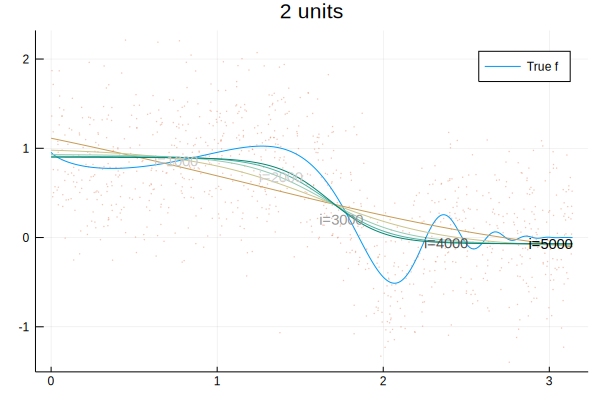

5000 iteration, loss=0.26859826763095573
 11.172050 seconds (27.15 M allocations: 2.340 GiB, 10.15% gc time)
1000 iteration, loss=0.2846570386999111
2000 iteration, loss=0.2683598305757201
3000 iteration, loss=0.262741484978865
4000 iteration, loss=0.25943117542968097


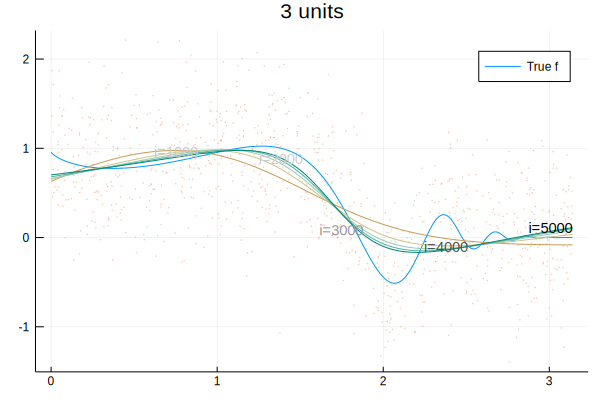

5000 iteration, loss=0.2570377233202576
  2.009545 seconds (2.37 M allocations: 1.422 GiB, 13.69% gc time)
1000 iteration, loss=0.2842855812658046
2000 iteration, loss=0.27069393504111344
3000 iteration, loss=0.2633978101419368
4000 iteration, loss=0.2586829376859415


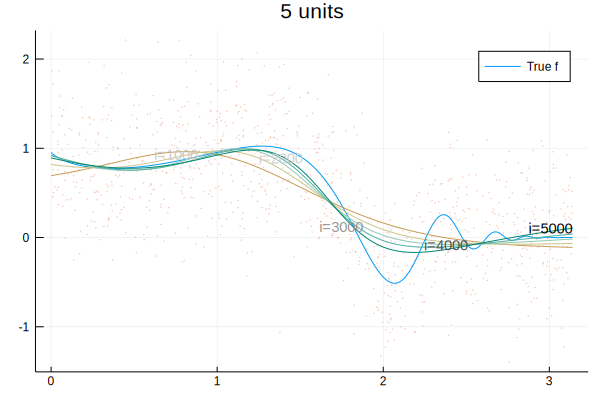

5000 iteration, loss=0.25482577956181757
  2.733501 seconds (2.37 M allocations: 2.094 GiB, 12.46% gc time)
1000 iteration, loss=0.31233148101641234
2000 iteration, loss=0.28653090843538065
3000 iteration, loss=0.2735517974980419
4000 iteration, loss=0.26152806261816874


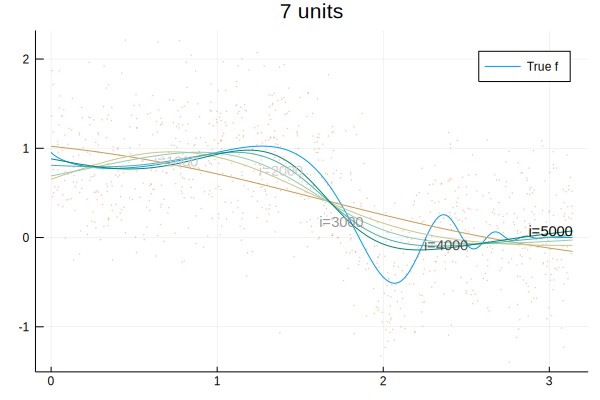

5000 iteration, loss=0.25627123980624983
  3.499641 seconds (2.37 M allocations: 2.767 GiB, 12.15% gc time)
1000 iteration, loss=0.29790117241477365
2000 iteration, loss=0.2791989484909314
3000 iteration, loss=0.2717057512289153
4000 iteration, loss=0.2679238358398165


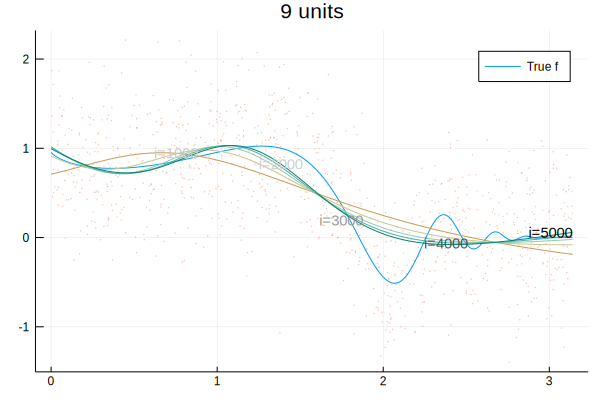

5000 iteration, loss=0.2650447255596423
  4.192781 seconds (2.37 M allocations: 3.439 GiB, 12.34% gc time)


In [3]:
figs = Array{typeof(plot(0)),1}(undef,length(rs))
for r in eachindex(rs)
  m = slp(rs[r])
  figs[r]=plot(xg, f.(xg), lab="True f", title="$(rs[r]) units")
  figs[r]=scatter!(x,y, markeralpha=0.4, markersize=1, markerstrokewidth=0, lab="")
  maxiter = 5000
  @time for i = 1:maxiter
    Flux.train!(m.loss, m.θ, [(x, y)], Flux.AMSGrad())
    if (i % (maxiter ÷ 5))==0
      l=Tracker.data(m.loss(x,y))
      println("$i iteration, loss=$l")
      loc=Int64.(ceil(length(xg)*i/maxiter))
      yg = Tracker.data(m.predict(xg))
      figs[r]=plot!(xg,yg, lab="", color=get(cscheme, i/maxiter), alpha=1.0,
                    annotations=(xg[loc], yg[loc],
                                 Plots.text("i=$i", i<maxiter/2 ? :left : :right, pointsize=10,
                                            color=get(cscheme, i/maxiter)) )
                    )
    end
  end
  display(figs[r])
end

Notice how even though a wider network can approximate $f$ better,
wider networks also take more training iterations to minimize the
loss. This is typical of any minimization algorithm --- the number of
iterations increases with the problem size. 

Each invocation of `Flux.train!` completes one iteration of gradient
descent. As you might guess from this API, it is common to train
neural networks for a fixed number of iterations instead of until
convergence to a local minimum. The number of training iterations can
act as a regularization parameter. 

## Chain interface

`Flux.jl` also contains some higher level functions for creating loss
functions for neural networks. Here is the same network as in the
previous code block, but using the higher level API.

2 units, 1 iterations, loss=3.898395
2 units, 600 iterations, loss=0.2884394
2 units, 1200 iterations, loss=0.26049888
2 units, 1800 iterations, loss=0.2520295
2 units, 2400 iterations, loss=0.24892555


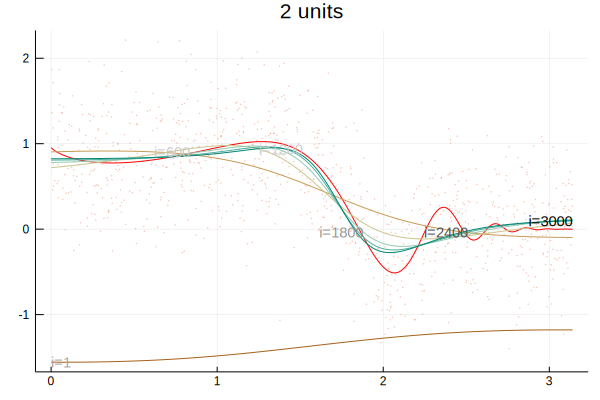

2 units, 3000 iterations, loss=0.24752173
  6.773747 seconds (17.30 M allocations: 1.100 GiB, 10.27% gc time)
3 units, 1 iterations, loss=0.8436227
3 units, 600 iterations, loss=0.30454156
3 units, 1200 iterations, loss=0.26601264
3 units, 1800 iterations, loss=0.25412825
3 units, 2400 iterations, loss=0.24968013
3 units, 3000 iterations, loss=0.24778149

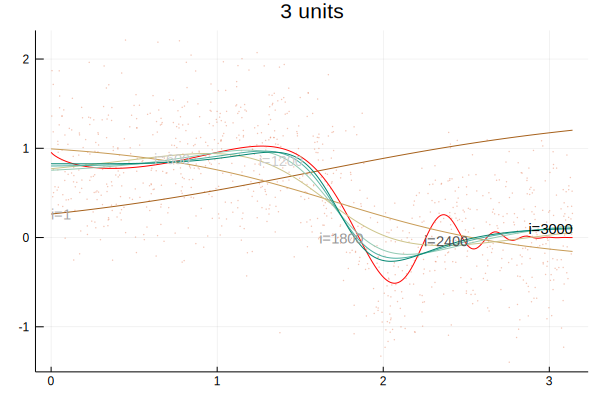


  1.293177 seconds (1.62 M allocations: 382.282 MiB, 7.04% gc time)
5 units, 1 iterations, loss=0.75660783
5 units, 600 iterations, loss=0.27854058
5 units, 1200 iterations, loss=0.26036808
5 units, 1800 iterations, loss=0.25410387
5 units, 2400 iterations, loss=0.2507338
5 units, 3000 iterations, loss=0.2488686

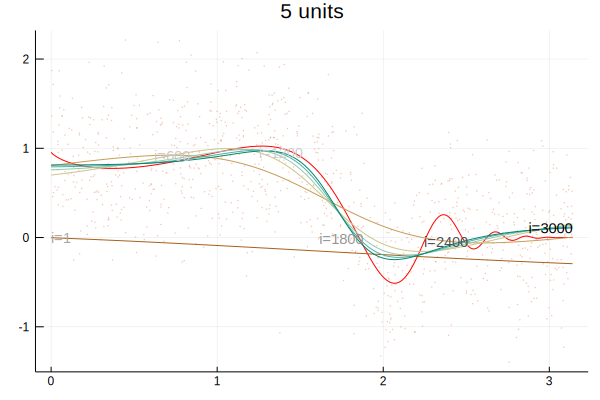


  1.578552 seconds (1.63 M allocations: 496.980 MiB, 6.74% gc time)
7 units, 1 iterations, loss=1.5810721
7 units, 600 iterations, loss=0.28373536
7 units, 1200 iterations, loss=0.26407453
7 units, 1800 iterations, loss=0.25863907
7 units, 2400 iterations, loss=0.25450802
7 units, 3000 iterations, loss=0.25175515

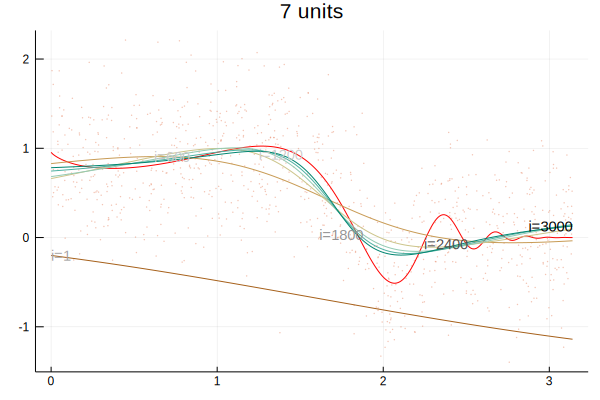


  1.905359 seconds (1.63 M allocations: 611.954 MiB, 6.49% gc time)
9 units, 1 iterations, loss=0.44208497
9 units, 600 iterations, loss=0.28651735
9 units, 1200 iterations, loss=0.2638471
9 units, 1800 iterations, loss=0.2578518
9 units, 2400 iterations, loss=0.2535174
9 units, 3000 iterations, loss=0.2511744

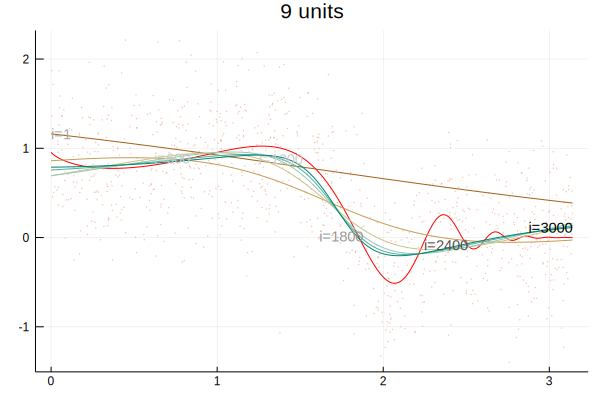


  2.092936 seconds (1.63 M allocations: 727.339 MiB, 6.51% gc time)


In [4]:
dimx = 1
figs = Array{typeof(plot(0)),1}(undef,length(rs))
initmfigs = Array{typeof(plot(0)),1}(undef,length(rs))
xt = reshape(Float32.(x), 1, length(x))
yt = reshape(Float32.(y), 1, length(y))
for r in eachindex(rs)
  l = rs[r]
  m = Chain(x->Flux.normalise(x, dims=2), Dense(dimx, l, Flux.σ), Dense(rs[r], 1))
  initmfigs[r] = plot(xg, Tracker.data(m[1:(end-1)](xg'))', lab="", legend=false)
  figs[r]=plot(xg, f.(xg), lab="", title="$(rs[r]) units", color=:red)
  figs[r]=scatter!(x,y, alpha=0.4, markersize=1, markerstrokewidth=0, lab="")
  maxiter = 3000
  @time for i = 1:maxiter
    Flux.train!((x,y)->Flux.mse(m(x),y), Flux.params(m), [(xt, yt)], Flux.AMSGrad() ) #,
                #cb = Flux.throttle(()->@show(Flux.mse(m(xt),yt)),100))
    if i==1 || (i % (maxiter ÷ 5))==0
      l=Tracker.data(Flux.mse(m(xt), yt))
      println("$(rs[r]) units, $i iterations, loss=$l")
      yg = Tracker.data(m(xg'))'
      loc=Int64.(ceil(length(xg)*i/maxiter))
      figs[r]=plot!(xg,yg, lab="", color=get(cscheme, i/maxiter), alpha=1.0,
                    annotations=(xg[loc], yg[loc],
                                 Plots.text("i=$i", i<maxiter/2 ? :left : :right, pointsize=10,
                                            color=get(cscheme, i/maxiter)) )
                    )
    end
  end
  display(figs[r])
end

The figures do not appear identical to the first example since the
initial values differ, and the above code first normalises the
$x$s. 

## Initial values
 
Initial values are especially important with neural networks because
activation functions tend to be flat at the extremes. This causes the
gradient of the loss function to vanish in some regions of the
parameter space. For gradient descent to be successful, it is
important to avoid regions with vanishing gradients. The default
initial values of $w$ and $b$ used by Flux tend to work better with
normalised $x$. The initial activation are shown below.

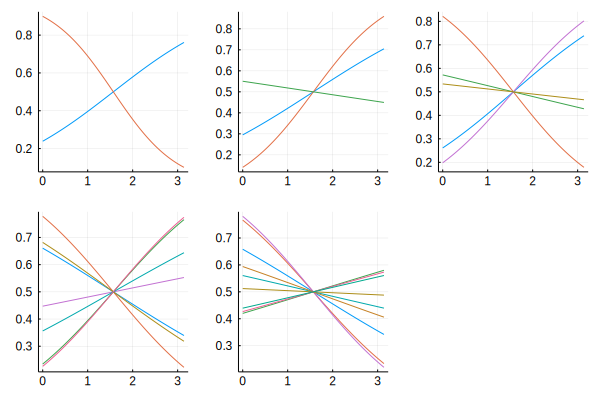

In [5]:
plot(initmfigs..., legend=false)

At these initial values, $w'x + b$, does change sign for each
activation, but $w'x$ is small enough that $\psi(w'x + b)$ is
approximately linear. This will make it initially difficult to
distinguish $\beta \psi'$ from $w$, 

We can improve the fit by choosing initial values even more
carefully.  The following code choses initial $w$ and $b$ to make sure
the activation functions vary nonlinearly in the support of $x$. 
The initial activations functions are plotted below.

In [6]:
dimx = 1
figs = Array{typeof(plot(0)),1}(undef,length(rs))
initmfigs = Array{typeof(plot(0)),1}(undef,length(rs))
xt = reshape(Float32.(x), 1, length(x))
yt = reshape(Float32.(y), 1, length(y))
for r in eachindex(rs)
  l = rs[r]
  m = Chain(Dense(dimx, l, Flux.σ), Dense(rs[r], 1))
  # adjust initial weights to make sure each node is nonlinear in support of X
  Tracker.update!(m[1].W, -m[1].W .+ sign.(Tracker.data(m[1].W))*2*π)
  # adjust initial intercepts to be in the support of w*x  
  Tracker.update!(m[1].b, -m[1].b .- m[1].W[:].*Float32.(π/(l+1):π/(l+1):π*l/(l+1)))
  # make initial output weights optimal given first layer
  X = vcat(1, Tracker.data(m[1](xt)))
  bols = (X*X') \ (X*Float32.(y))
  Tracker.update!(m[2].W, -m[2].W .+ bols[2:end]')
  Tracker.update!(m[2].b, -m[2].b .- Float32(Tracker.data(mean(m(xt) .- yt))))
  initmfigs[r] = plot(xg, Tracker.data(m[1](xg'))', lab="", legend=false)
  figs[r]=plot(xg, f.(xg), lab="", title="$(rs[r]) units", color=:red)
  figs[r]=scatter!(x,y, alpha=0.4, markersize=1, markerstrokewidth=0, lab="")
  maxiter = 3000
  @time for i = 1:maxiter
    Flux.train!((x,y)->Flux.mse(m(x),y), Flux.params(m), [(xt, yt)], Flux.AMSGrad() ) #,
    #cb = Flux.throttle(()->@show(Flux.mse(m(xt),yt)),100))
    if i==1 || (i % (maxiter ÷ 5))==0
      l=Tracker.data(Flux.mse(m(xt), yt))
      println("$(rs[r]) units, $i iterations, loss=$l")
      yg = Tracker.data(m(xg'))'
      loc=Int64.(ceil(length(xg)*i/maxiter))
      figs[r]=plot!(xg,yg, lab="", color=get(cscheme, i/maxiter), alpha=1.0,
                    annotations=(xg[loc], yg[loc],
                                 Plots.text("i=$i", i<maxiter/2 ? :left : :right, pointsize=10,
                                            color=get(cscheme, i/maxiter)) )
                    )
    end
  end
end
nothing

2 units, 1 iterations, loss=0.31044248
2 units, 600 iterations, loss=0.26069954
2 units, 1200 iterations, loss=0.26019543
2 units, 1800 iterations, loss=0.25949666
2 units, 2400 iterations, loss=0.2529835
2 units, 3000 iterations, loss=0.24798498
  1.162961 seconds (1.64 M allocations: 314.121 MiB, 9.23% gc time)
3 units, 1 iterations, loss=0.26194268
3 units, 600 iterations, loss=0.24812546
3 units, 1200 iterations, loss=0.24664249
3 units, 1800 iterations, loss=0.24575293
3 units, 2400 iterations, loss=0.245133
3 units, 3000 iterations, loss=0.24466912
  1.270272 seconds (1.55 M allocations: 367.676 MiB, 7.42% gc time)
5 units, 1 iterations, loss=0.25909808
5 units, 600 iterations, loss=0.2458154
5 units, 1200 iterations, loss=0.24411397
5 units, 1800 iterations, loss=0.243257
5 units, 2400 iterations, loss=0.24270937
5 units, 3000 iterations, loss=0.24232228
  1.580438 seconds (1.56 M allocations: 482.374 MiB, 7.65% gc time)
7 units, 1 iterations, loss=0.25009957
7 units, 600 iterat

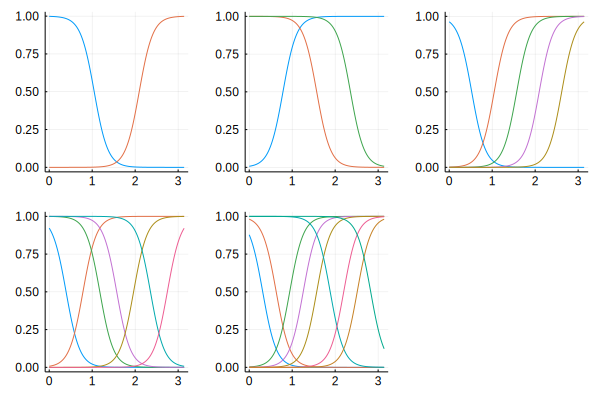

In [7]:
display(plot(initmfigs..., legend=false))

And the fit figures.

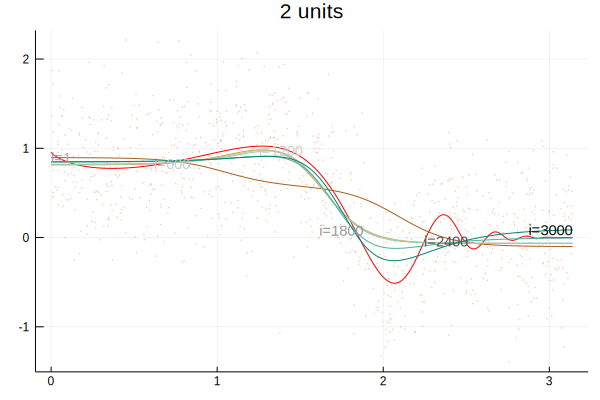

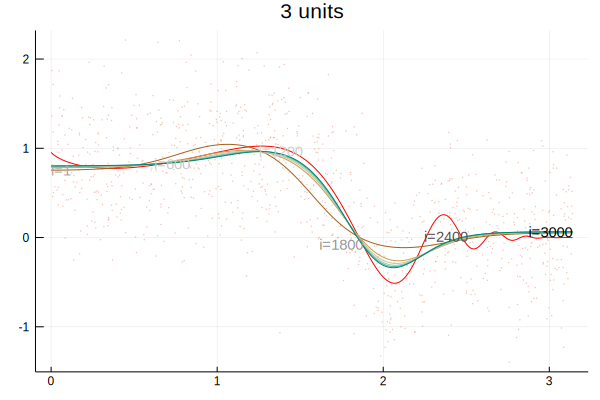

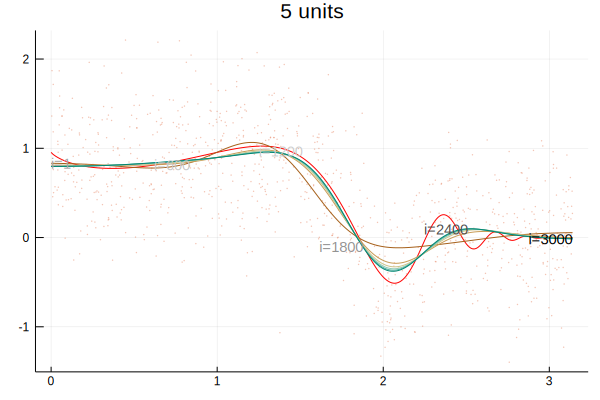

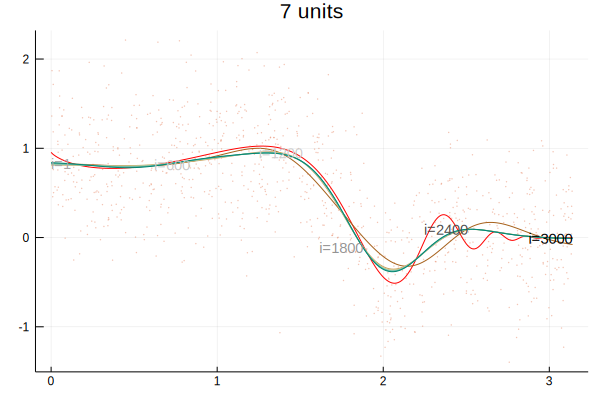

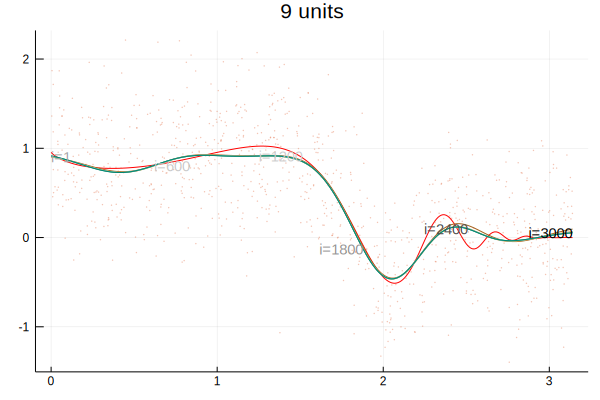

In [8]:
for f in figs
  display(f)
end

## Rectified linear

Large applications of neural networks often use rectified linear
activation for efficiency. Let's see how the same example behaves with
(leaky) rectified linear activation.

2 units, 1 iterations, loss=0.27056533
2 units, 600 iterations, loss=0.2655909
2 units, 1200 iterations, loss=0.26488587
2 units, 1800 iterations, loss=0.26437145
2 units, 2400 iterations, loss=0.2638787
2 units, 3000 iterations, loss=0.26349062
  1.546242 seconds (3.06 M allocations: 386.321 MiB, 10.37% gc time)
3 units, 1 iterations, loss=0.28437954
3 units, 600 iterations, loss=0.2652238
3 units, 1200 iterations, loss=0.26243296
3 units, 1800 iterations, loss=0.2612343
3 units, 2400 iterations, loss=0.26051247
3 units, 3000 iterations, loss=0.2600892
  1.178841 seconds (1.54 M allocations: 367.538 MiB, 22.08% gc time)
5 units, 1 iterations, loss=0.30398947
5 units, 600 iterations, loss=0.26036
5 units, 1200 iterations, loss=0.2533343
5 units, 1800 iterations, loss=0.2521995
5 units, 2400 iterations, loss=0.25166833
5 units, 3000 iterations, loss=0.2512241
  1.066745 seconds (1.55 M allocations: 482.236 MiB, 8.24% gc time)
7 units, 1 iterations, loss=0.25384596
7 units, 600 iteration

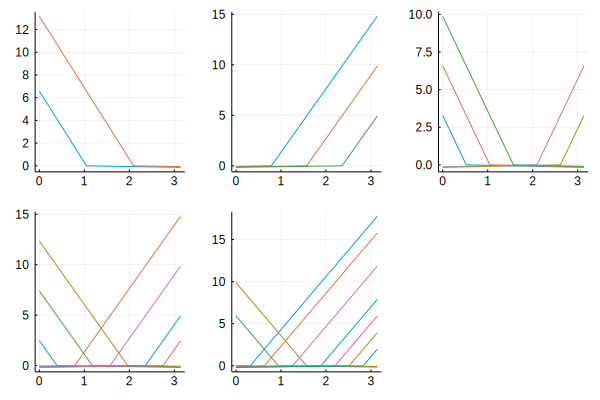

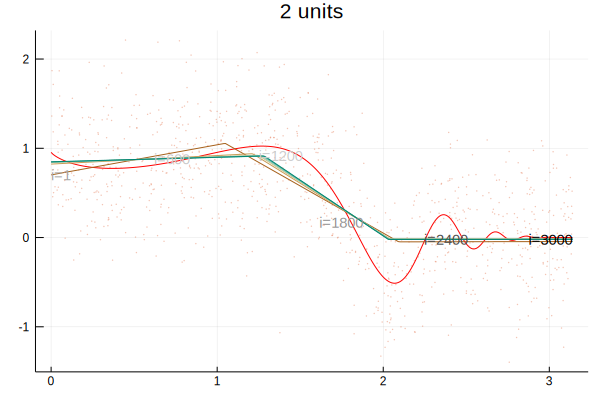

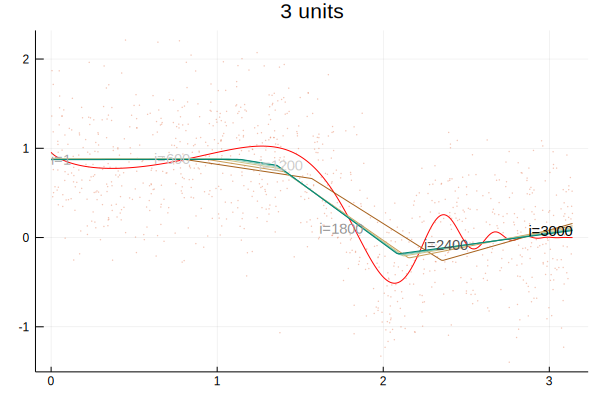

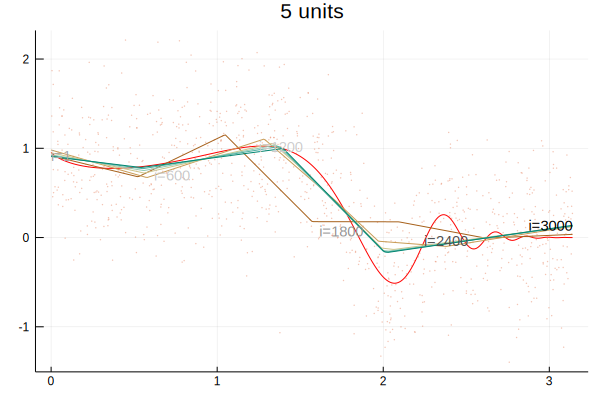

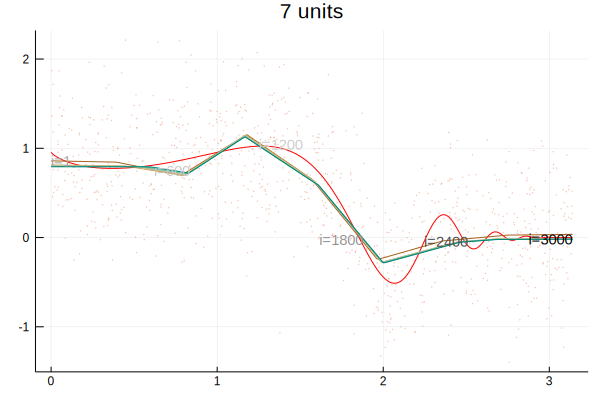

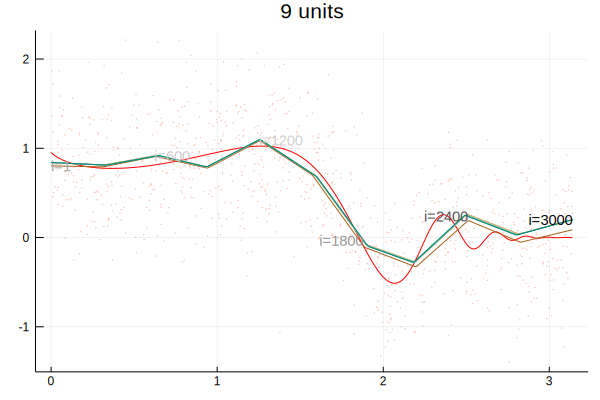

9 units, 3000 iterations, loss=0.25192693
  1.140133 seconds (1.55 M allocations: 712.594 MiB, 10.78% gc time)


In [9]:
dimx = 1
figs = Array{typeof(plot(0)),1}(undef,length(rs))
for r in eachindex(rs)
  l = rs[r]
  m = Chain(Dense(dimx, rs[r], Flux.leakyrelu), Dense(rs[r], 1)) # notice the change
  # adjust initial weights to make sure each node is nonlinear in support of X
  Tracker.update!(m[1].W, -m[1].W .+ sign.(Tracker.data(m[1].W))*2*π)
  # adjust initial intercepts to be in the support of w*x  
  Tracker.update!(m[1].b, -m[1].b .- m[1].W[:].*Float32.(π/(l+1):π/(l+1):π*l/(l+1)))
  # make initial output weights optimal given first layer
  X = vcat(1, Tracker.data(m[1](xt)))
  bols = (X*X') \ (X*Float32.(y))
  Tracker.update!(m[2].W, -m[2].W .+ bols[2:end]')
  Tracker.update!(m[2].b, -m[2].b .- Float32(Tracker.data(mean(m(xt) .- yt))))
  initmfigs[r] = plot(xg, Tracker.data(m[1:(end-1)](xg'))', lab="", legend=false)
  figs[r]=plot(xg, f.(xg), lab="", title="$(rs[r]) units", color=:red)
  figs[r]=scatter!(x,y, alpha=0.4, markersize=1, markerstrokewidth=0, lab="")
  maxiter = 3000
  @time for i = 1:maxiter
    Flux.train!((x,y)->Flux.mse(m(x),y), Flux.params(m), [(xt, yt)], Flux.AMSGrad() ) #,
                #cb = Flux.throttle(()->@show(Flux.mse(m(xt),yt)),100))
    if i==1 || (i % (maxiter ÷ 5))==0
      l=Tracker.data(Flux.mse(m(xt), yt))
      println("$(rs[r]) units, $i iterations, loss=$l")
      yg = Tracker.data(m(xg'))'
      loc=Int64.(ceil(length(xg)*i/maxiter))
      figs[r]=plot!(xg,yg, lab="", color=get(cscheme, i/maxiter), alpha=1.0,
                    annotations=(xg[loc], yg[loc],
                                 Plots.text("i=$i", i<maxiter/2 ? :left : :right, pointsize=10,
                                            color=get(cscheme, i/maxiter)) )
                    )
    end
  end
end
display(plot(initmfigs..., legend=false) )

for f in figs
  display(f)
end

## Stochastic Gradient descent

The above examples all used the full data in each iteration of
gradient descent. Computation can be reduced and the parameter space
can possibly be explored more by using stochastic gradient descent. In
stochastic gradient descent, a subset (possibly even of size 1) of the
data is used to compute the gradient for each iteration. To accomplish
this in Flux, we should give the `Flux.train!` function an array of
tuples of data consisting of the subsets to be used in iteration. Each
call to `Flux.train!` loops over all tuples of data, doing one
gradient descent iteration for each. This whole process is referred to
as a training epoch. You could use (the below does not) Flux's
`@epochs` macro for running multiple training epochs without writing a loop.

2 units, 1 iterations, loss=0.37304738
2 units, 600 iterations, loss=0.3014495
2 units, 1200 iterations, loss=0.3014429
2 units, 1800 iterations, loss=0.30142576
2 units, 2400 iterations, loss=0.3014196
2 units, 3000 iterations, loss=0.30141827
  4.330946 seconds (14.94 M allocations: 802.917 MiB, 5.46% gc time)
3 units, 1 iterations, loss=0.283131
3 units, 600 iterations, loss=0.25058612
3 units, 1200 iterations, loss=0.25052458
3 units, 1800 iterations, loss=0.25055146
3 units, 2400 iterations, loss=0.25045812
3 units, 3000 iterations, loss=0.25049078
  4.169498 seconds (14.67 M allocations: 859.680 MiB, 5.60% gc time)
5 units, 1 iterations, loss=0.25550422
5 units, 600 iterations, loss=0.24900931
5 units, 1200 iterations, loss=0.24851249
5 units, 1800 iterations, loss=0.24801165
5 units, 2400 iterations, loss=0.24750069
5 units, 3000 iterations, loss=0.24706423
  4.337831 seconds (14.67 M allocations: 984.770 MiB, 6.19% gc time)
7 units, 1 iterations, loss=0.25267115
7 units, 600 it

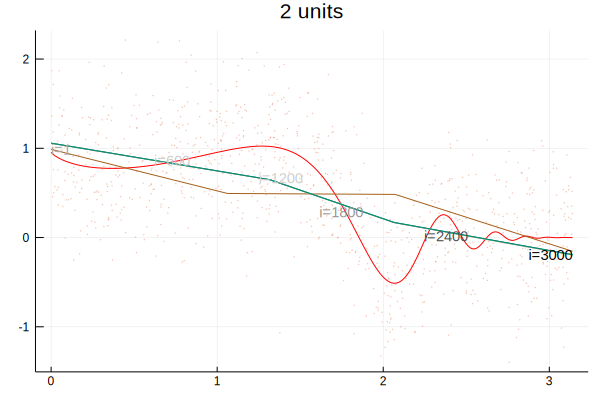

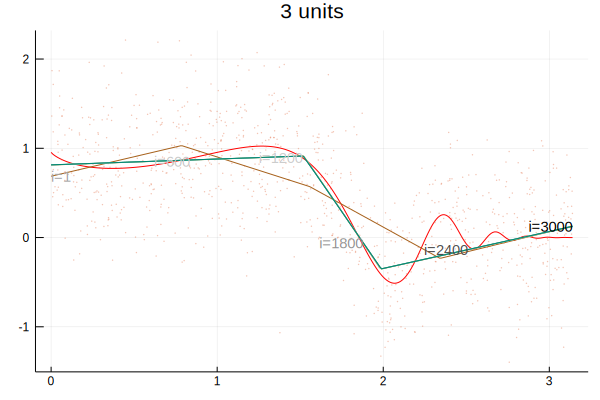

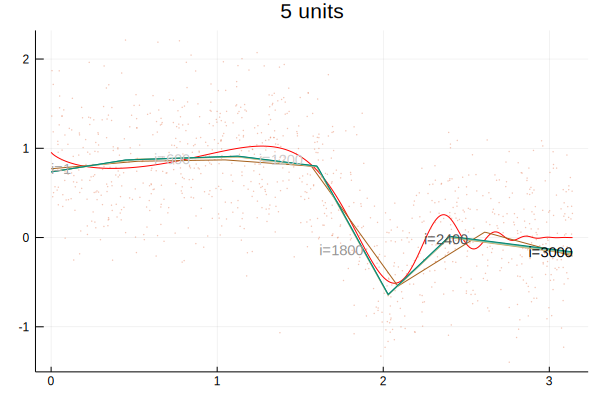

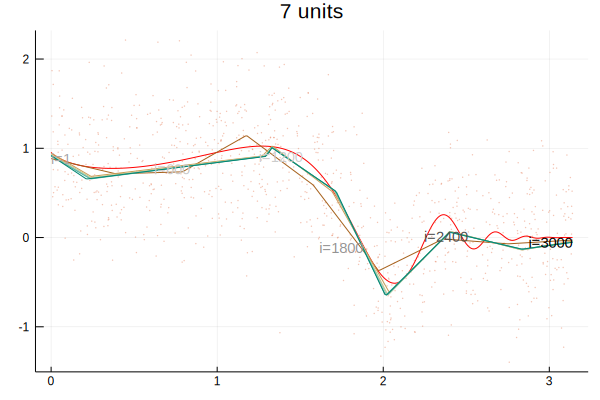

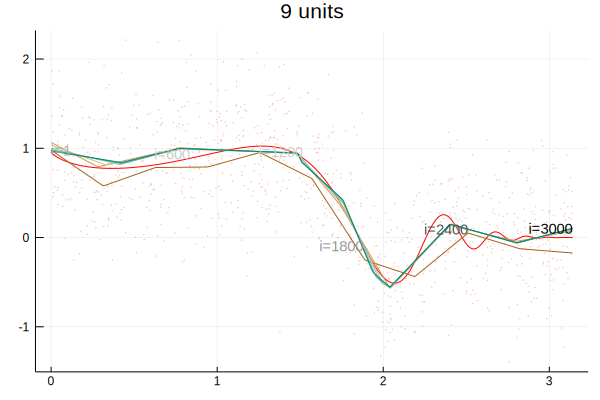


  4.566029 seconds (14.67 M allocations: 1.198 GiB, 7.47% gc time)


In [10]:
dimx = 1
figs = Array{typeof(plot(0)),1}(undef,length(rs))
for r in eachindex(rs)
  l = rs[r]
  m = Chain(Dense(dimx, rs[r], Flux.leakyrelu), Dense(rs[r], 1)) # notice the change
  # adjust initial weights to make sure each node is nonlinear in support of X
  Tracker.update!(m[1].W, -m[1].W .+ sign.(Tracker.data(m[1].W))*2*π)
  # adjust initial intercepts to be in the support of w*x  
  Tracker.update!(m[1].b, -m[1].b .- m[1].W[:].*Float32.(π/(l+1):π/(l+1):π*l/(l+1)))
  # make initial output weights optimal given first layer
  X = vcat(1, Tracker.data(m[1](xt)))
  bols = (X*X') \ (X*Float32.(y))
  Tracker.update!(m[2].W, -m[2].W .+ bols[2:end]')
  Tracker.update!(m[2].b, -m[2].b .- Float32(Tracker.data(mean(m(xt) .- yt))))
  initmfigs[r] = plot(xg, Tracker.data(m[1:(end-1)](xg'))', lab="", legend=false)
  figs[r]=plot(xg, f.(xg), lab="", title="$(rs[r]) units", color=:red)
  figs[r]=scatter!(x,y, alpha=0.4, markersize=1, markerstrokewidth=0, lab="")
  maxiter = 3000
  @time for i = 1:maxiter
    Flux.train!((x,y)->Flux.mse(m(x),y), Flux.params(m), 
                # partition data into 100 batches
                [(xt[:,p], yt[:,p]) for p in Base.Iterators.partition(1:length(y), 100)], 
                Flux.AMSGrad() ) #,
    if i==1 || (i % (maxiter ÷ 5))==0
      l=Tracker.data(Flux.mse(m(xt), yt))
      println("$(rs[r]) units, $i iterations, loss=$l")
      yg = Tracker.data(m(xg'))'
      loc=Int64.(ceil(length(xg)*i/maxiter))
      figs[r]=plot!(xg,yg, lab="", color=get(cscheme, i/maxiter), alpha=1.0,
                    annotations=(xg[loc], yg[loc],
                                 Plots.text("i=$i", i<maxiter/2 ? :left : :right, pointsize=10,
                                            color=get(cscheme, i/maxiter)) )
                    )
    end
  end
end

for f in figs
  display(f)
end

Here we see an in sample MSE about as low as the best previous
result. Note, however, the longer training time. Each "iteration"
above is an epoch, which consists of 10 gradient descent steps using
the 10 different subsets (or batches) of data of size 100.


# Rate of convergence


- @chen1999
- $f(x) = \Er[y|x]$ with Fourier representation
$$ f(x) = \int e^{i a'x} d\sigma_f(a) $$
  where $\int (\sqrt{a'a} \vee 1) d|\sigma_f|(a) < \infty$
- Network sieve :
$$ \begin{align*}
\mathcal{G}_n = \{ &
g: g(x) = \sum_{j=1}^{r_n} \beta_j (a_j'a_j \vee 1)^{-1}
\psi(a_j'x + b_j), \\ & \norm{\beta}_1 \leq B_n \}
\end{align*}
$$

The setup in @chen1999 is more general. They consider estimating both
$f$ and its first $m$ derivatives. Here, we focus on the case of just
estimating $f$. @chen1999 also consider estimation of functions other
than conditional expectations.

The restriction on $f$ in the second bullet is used to control
approximation error. The second bullet says that $f$ is the inverse
Fourier transform of measure $\sigma_f$. The bite of the restriction
on $f$ comes from the requirement that $\sigma_f$ be absolutely
integral, $\int (\sqrt{a'a} \vee 1) d|\sigma_f|(a) < \infty$. It would
be a good exercise to check whether this restriction is satisfied by
some familiar types of functions. @barron1993 first showed that neural
networks approximate this class of functions well, and compares the
approximation rate of neural networks to other function approximation
results.

TODO: 
- clean up this section
- add simulations demonstrating convergence rate? 


# References